# Setups

In [ ]:
import os
import numpy as np
import tifffile
import torch
from matplotlib import pyplot as plt
import albumentations as Alb
from skimage import transform

# Config

In [ ]:
class CFG:
    """
    Configuration class for the blood vessel segmentation project.
    """

    # ============== Model Configuration =============
    MODEL_NAME = 'Unet'
    BACKBONE = 'se_resnext50_32x4d'
    IN_CHANNEL = 1  # Number of input channels (e.g., 1 for grayscale images)
    OUT_CHANNEL = 1 # Number of output channels

    # ============== Image Processing Settings =============
    INPUT_IMAGE_SIZE = (1024, 1024)  # Size of the input images (height x width)
    
    # =============
    # = Training and Validation Parameters =============
    VALID_ID = 1  # ID for validation dataset or fold
    BATCH_SIZE = 16  # Batch size for model training
    THRESHOLD_PERCENTILE = 0.0014109  # Threshold for post-processing
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 50
    NUM_WORKERS = 0 # Number of threds

    # ============== Model Paths =============
    # List of paths to trained model weights
    MODEL_PATHS = [
        "/path/to/model1.pt",
        "/path/to/model2.pt",
        # Add more model paths as needed
    ]

    # ============== Data Paths =============
    DATASET_NAME = "kidney_1_dense"
    DATASET_DIRECTORY = os.path.join("..", "blood-vessel-segmentation")
    TRAIN_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "train", DATASET_NAME)
    TEST_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "test", DATASET_NAME)

## Custom Dataset Class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_path, mask_path):
        self.image_path = image_path
        self.mask_path = mask_path
        self.image_filenames = sorted([os.path.join(image_path, filenames) for filenames in os.listdir(image_path) if filenames.endswith('.tif')])
        self.mask_filenames = sorted([os.path.join(mask_path, filenames) for filenames in os.listdir(image_path) if filenames.endswith('.tif')])

    def __getitem__(self, index):
        

# tensor image

In [ ]:
data_set = 'kidney_2'

image_path = os.path.join('..', 'data', 'train', data_set, 'images')
label_path = os.path.join('..', 'data', 'train', data_set, 'labels')

image_files = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) if f.endswith('.tif')])

def display_image(tensor):
    if isinstance(tensor, torch.Tensor):
        # If the input is a PyTorch tensor
        if len(tensor.shape) == 4:
            tensor = tensor.squeeze(0)

        numpy_image = tensor.cpu().numpy()

        if len(numpy_image.shape) == 3 and numpy_image.shape[0] == 1:
            numpy_image = numpy_image.squeeze(0)

        if len(numpy_image.shape) == 3:
            numpy_image = numpy_image.transpose(1, 2, 0)

    elif isinstance(tensor, np.ndarray):
        # If the input is a NumPy array
        numpy_image = tensor

        if len(numpy_image.shape) == 3 and numpy_image.shape[0] == 1:
            numpy_image = numpy_image.squeeze(0)
    
    plt.imshow(numpy_image, cmap='gray')
    plt.axis('off')
    plt.show()

True True


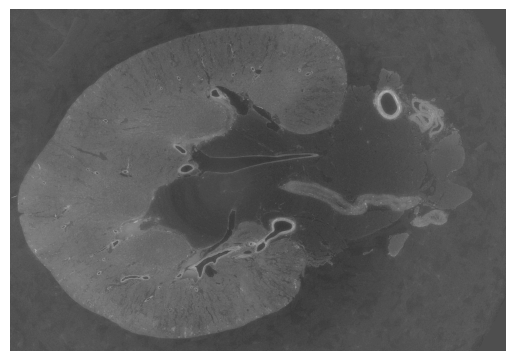

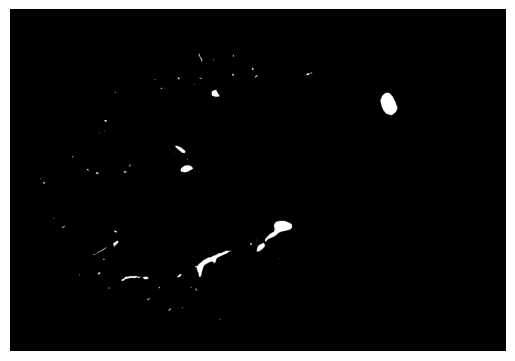

True True


In [13]:

first_image = tifffile.imread(image_files[981])
first_label = tifffile.imread(label_files[981])

is_image = isinstance(first_image, np.ndarray)
is_mask = isinstance(first_label, np.ndarray)
print(is_image, is_mask)

# Convert tensor floats32
first_image_tensor = torch.from_numpy(first_image.astype(np.float32))
first_label_tensor = torch.from_numpy(first_label.astype(np.float32))

display_image(first_image_tensor)
display_image(first_label_tensor)

is_image_tensor = isinstance(first_image_tensor, torch.Tensor)
is_mask_tensor = isinstance(first_label_tensor, torch.Tensor)
print(is_image_tensor, is_mask_tensor)

# 0.1 Image Augmentation

In [ ]:
def Augement_image(image, mask):

    image_dense = torch.from_numpy(image.astype(np.float32))
    mask_dense = torch.from_numpy(mask.astype(np.float32))

    if len(image_dense.shape) == 2:
        image_dense = image_dense.unsqueeze(0)

    image_np = image_dense.permute(1, 2, 0).numpy()
    mask_np = mask_dense.numpy()

    image_list = [None, None, None, None]
    mask_list = [None, None, None, None]
    
    transform_rotate_90 = Alb.Compose([
        Alb.Rotate(limit=90, p=0.5)
    ])

    # Original image
    image_list[0] = image_np
    mask_list[0] = mask_np

    # Original image with 90-degree rotation
    augmented_rotate_90 = transform_rotate_90(image=image_np, mask=mask_np)
    image_list[1], mask_list[1] = augmented_rotate_90['image'], augmented_rotate_90['mask']

    # Original image with 180-degree rotation
    augmented_rotate_180 = transform_rotate_90(image=image_list[1], mask=mask_list[1])   
    image_list[2], mask_list[2] = augmented_rotate_180['image'], augmented_rotate_180['mask']

    # Original image with 270-degree rotation
    augmented_rotate_270 = transform_rotate_90(image=image_list[2], mask=mask_list[2])
    image_list[3], mask_list[3] = augmented_rotate_270['image'], augmented_rotate_270['mask']

    augmented_data_zip = list(zip(*[image_list, mask_list]))

    return augmented_data_zip


[(array([[[34092.],
        [32989.],
        [33755.],
        ...,
        [32768.],
        [32768.],
        [32768.]],

       [[33363.],
        [32322.],
        [33004.],
        ...,
        [32768.],
        [32768.],
        [32768.]],

       [[33308.],
        [33045.],
        [32822.],
        ...,
        [32768.],
        [32768.],
        [32768.]],

       ...,

       [[32314.],
        [33162.],
        [32016.],
        ...,
        [32768.],
        [32768.],
        [32768.]],

       [[32913.],
        [32751.],
        [32995.],
        ...,
        [32768.],
        [32768.],
        [32768.]],

       [[32938.],
        [33945.],
        [33908.],
        ...,
        [32768.],
        [32768.],
        [32768.]]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 

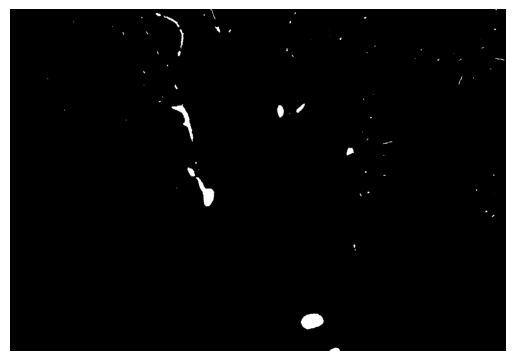

In [11]:
# Load an example image and label
first_image = tifffile.imread(image_files[981])
first_label = tifffile.imread(label_files[981])

# Augment the image and label
# augmented_image, augmented_mask = Augement_image(first_image, first_label)
augmented_zip = Augement_image(first_image, first_label)



# Show the augmented image
# display_image(augmented_image)
# display_image(augmented_mask)

# is_image_tensor = isinstance(augmented_image, np.ndarray)
# is_mask_tensor = isinstance(augmented_mask, np.ndarray)
# print(is_image_tensor, is_mask_tensor)
print(augmented_zip)
display_image(augmented_zip[-1][-1])